# Step14 모델 저장 및 로드
텐서플로는 모델 그래프와 학습 결과 가중치를 파일에 저장한다.

학습 결과는 그래프 구조와 가중치 체크포인트로 구성되며 그래프 구조는 이진 파일, 텍스트 파일로 저장된다.

opencv와 같은 라이브러리에서 학습 결과를 로드해서 사용하려면, 체크포인트의 가중치를 GraphDef에 상수로 넣어 하나의 이진파일로 저장하는 **동결된 이진파일**이 필요하다
<br><br><br>

1. 모델 전체 저장/로드
model.svae()는 모델 전체(모델구조, 가중치 최적화 방법)를 HDF5 형식 또는 Tensorflow 형식으로 저장한다.
keras.models.load_model()은 모델을 로드한다.
```python
model_save("./RES/1401.h5") #HDF5.keras format
model = tf.keras.models.load_model("./RES/1401.h5")
```

2. 가중치 수동저장
학습된 가중치를 model.save_weights()로 이진 파일로 저장하고, 모델을 생성하고, model.load_weights()로 가중치를 로드한다.
```python
model.save_weights("./RES/weights/1401") #1. 이진 파일 저장
#2. 모델 생성
model.load_weights("./RES/weights/1401") #3. 가중치 로드
```

3. 체코포인트 콜백
tf.keras.callbacks.ModelCheckpoint()로 가중치 저장(save_weights_only = True), 저장 주기 50 에폭을 갖는 체크포인트 콜백함수 객체 cp_callback를 생성하고, model.fit()에서 callbacks=[cp_callback] 콜백을 설정하여 주기적으로 가중치를 체크포인트 파일에 저장한다. 모델을 생성하고, model.load_weights()로 가중치를 로드한다.
```python
file path = "./RES/ckpt/1401-[epoch:04d].ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath, verbose=0, save_weights_only = True, save_freq=50)
ret = model.fit(X, y_true, epochs = 100, callbacks=[cp_callback], verbose=2)
```
```python
latest = tf.train.latest_checkpoint("./RES/ckpt")
model.load_weights(latest)
```

4. 모델 동결(freezing)
자동 그래프 기능을 갖는 tf.function()과 get_concreate_function() 메서드를 사용하여 full_model에 모델 구조를 저장한다. convert_varialbes_to_convert_v2()를 사용하여 full_model의 변수의 가중치를 상수화로 동결한 frozeon_func 객체를 생성하고, tf.io.write_graph()로 동결된 그래프 frozen_func_graph를 이진 파일 "frozen_graph.pb"에 출력한다.
```python
#Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concreate_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
```
```python
#Get frozen ConcrateFunction
from tensorflow.python.framework.convert_to_constansts import convert_variables_to_constants_v2
frozen_fucn = convert_variables_to_constants_v2(full_model)
tf.io.write_graph(graph_or_graph_def = frozen_fuhnc.graph
                  logdir="./checkpoints",
                  name="frozen_grpah.pb",
                  as_text=False)
```

## step14_01
### model = tf.keras.Model(): n차 다항식 회귀와 모델 저장

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def dataset(train_size=100): # tensorflow    
     tf.random.set_seed(1)
     x = tf.linspace(-5.0, 5.0, num=train_size)
     y = 3.0*x**3 + 2.0*x**2 + x + 4.0
     y += tf.random.normal([train_size], mean=0.0, stddev = 30.0)
     return x, y

x, y_true = dataset(20)

# n-차 다항식 회귀
n = 3
X = np.ones(shape = (len(x), n+1), dtype=np.float32)
for i in range(1, n+1):
     X[:, i] = x**i

inputs = tf.keras.layers.Input(shape=(n+1,))
outputs = tf.keras.layers.Dense(units=1, use_bias=False)(inputs) #False는 뉴런에 bias가 없고 w0=b로 하기 위함.
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')
ret = model.fit(X, y_true, epochs=100, verbose=2)

#1: 모델 전체 저장
import os
if not os.path.exists("./RES"):
     os.mkdir("./RES")
model.save("./RES/1401.h5")   # HDF5, keras format

#2: 모델 구조 저장
json_string = model.to_json()
import json
file = open("./RES/1401.model", 'w')
json.dump(json_string, file)
file.close()
 
#3: 가중치 저장
model.save_weights("./RES/weights/1401")
 
#4: 학습중에 체크포인트 저장
filepath = "RES/ckpt/1401-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
              filepath, verbose=0, save_weights_only=True, save_freq=50)
#save_weights_only=True는 가중치만 저장할 것, save_freq=50는 epoch 50마다 저장
ret = model.fit(X, y_true, epochs=100, callbacks = [cp_callback], verbose=0)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 - 1s - loss: 14056.0576 - 611ms/epoch - 611ms/step
Epoch 2/100
1/1 - 0s - loss: 10069.9756 - 20ms/epoch - 20ms/step
Epoch 3/100
1/1 - 0s - loss: 7810.0078 - 15ms/epoch - 15ms/step
Epoch 4/100
1/1 - 0s - loss: 6247.4556 - 19ms/epoch - 19ms/step
Epoch 5/100
1/1 - 0s - loss: 5080.2646 - 6ms/epoch - 6ms/step
Epoch 6/100
1/1 - 0s - loss: 4173.0161 - 7ms/epoch - 7ms/step
Epoch 7/100
1/1 - 0s - loss: 3451.5508 - 8ms/epoch - 8ms/step
Epoch 8/100
1/1

#1: 모델 전체(모델 구조, 가중치, 최적화 방법)을 하나의 파일 "./RES/1401.h5"에 저장한다.

#2: json으로 모델 구조를 저장한다.

#3: "./RES/weights" 폴더에 학습된 가중치를 파일로 저장한다.

#4: "RES/ckpt/" 폴더에 50에폭 마다 가중치를 체크 포인트 파일에 저장한다.

## step14_02
### model = tf.keras.models.load_model(): 모델 전체 로드

loss: 444.83660888671875
len(model.layers): 2
weights: [[-5.116239 ]
 [ 4.643714 ]
 [ 2.6247003]
 [ 2.805561 ]]
1/1 [==============================] - 0s 140ms/step


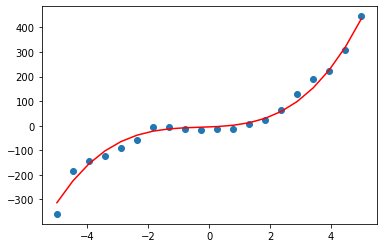

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def dataset(train_size=100): # tensorflow    
     tf.random.set_seed(1)
     x = tf.linspace(-5.0, 5.0, num=train_size)
     y = 3.0*x**3 + 2.0*x**2 + x + 4.0
     y += tf.random.normal([train_size], mean=0.0, stddev = 30.0)
     return x, y
x, y_true = dataset(20)

# n-차 다항식 회귀
n = 3
X = np.ones(shape = (len(x), n+1), dtype=np.float32)
for i in range(1, n+1):
     X[:, i] = x**i
     
#1: 모델 전체 로드
model = tf.keras.models.load_model("./RES/1401.h5")

#2: 모델 평가, 예측, 그래프 표시: model.evaluate로 훈련 데이터 X, y_true에 적용하여 손실함수 loss를 계산한다.
loss = model.evaluate(X, y_true, verbose=0) # 0 = silent
print("loss:", loss)

print("len(model.layers):", len(model.layers)) # 2
#print(model.get_weights())  # weights
print("weights:", model.layers[1].weights[0].numpy())

#3: 예측, 그래프 표시
plt.scatter(x, y_true) 
y_pred = model.predict(X)
plt.plot(x, y_pred, color='red')
plt.show()



## step14_03
### json 모델 구조와 가중치 로드: (다시 학습 시키기)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
loss: 444.83660888671875
len(model.layers): 2
weights: [[-5.116239 ]
 [ 4.643714 ]
 [ 2.6247003]
 [ 2.805561 ]]
1/1 [==============================] - 0s 93ms/step


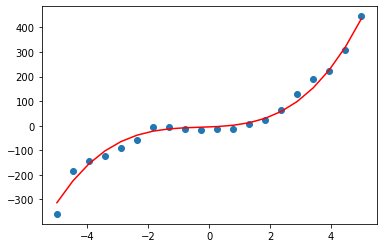

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def dataset(train_size=100): # tensorflow    
     tf.random.set_seed(1)
     x = tf.linspace(-5.0, 5.0, num=train_size)
     y = 3.0*x**3 + 2.0*x**2 + x + 4.0
     y += tf.random.normal([train_size], mean=0.0, stddev = 30.0)
     return x, y
x, y_true = dataset(20)

# n-차 다항식 회귀
n = 3
X = np.ones(shape = (len(x), n+1), dtype=np.float32)
for i in range(1, n+1):
     X[:, i] = x**i

##inputs = tf.keras.layers.Input(shape=(n+1,))
##outputs = tf.keras.layers.Dense(units=1, use_bias=False)(inputs)
##model = tf.keras.Model(inputs=inputs, outputs=outputs)
##model.summary()

#1: 모델 구조 로드
import json
file = open("./RES/1401.model", 'r')
json_model = json.load(file)
file.close()
model = tf.keras.models.model_from_json(json_model)
model.summary()

#2
opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

#3
model.load_weights("./RES/weights/1401")    # 가중치 로드 
loss = model.evaluate(X, y_true, verbose=0) # 0 = silent
print("loss:", loss)
print("len(model.layers):", len(model.layers)) # 1
#print(model.get_weights())  # weights
print("weights:", model.layers[1].weights[0].numpy())

#4
y_pred = model.predict(X)
plt.scatter(x, y_true) 
plt.plot(x, y_pred, color='red')
plt.show()


## step14_04
### tf.keras.models.load_model(): 모델 전체 로드

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
latest= ./RES/ckpt\1401-0100.ckpt
loss: 421.67681884765625
len(model.layers): 2
weights: [[-8.211505 ]
 [ 6.419797 ]
 [ 2.7704053]
 [ 2.7454317]]
1/1 [==============================] - 0s 40ms/step


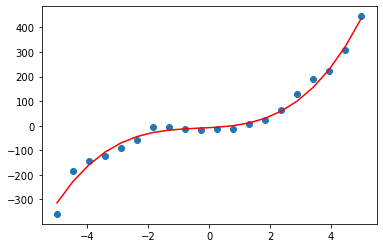

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def dataset(train_size=100): # tensorflow    
     tf.random.set_seed(1)
     x = tf.linspace(-5.0, 5.0, num=train_size)
     y = 3.0*x**3 + 2.0*x**2 + x + 4.0
     y += tf.random.normal([train_size], mean=0.0, stddev = 30.0)
     return x, y
x, y_true = dataset(20)

# n-차 다항식 회귀
n = 3
X = np.ones(shape = (len(x), n+1), dtype=np.float32)
for i in range(1, n+1):
     X[:, i] = x**i

##inputs = tf.keras.layers.Input(shape=(n+1,))
##outputs = tf.keras.layers.Dense(units=1, use_bias=False)(inputs)
##model = tf.keras.Model(inputs=inputs, outputs=outputs)
##model.summary()

#1: 모델 구조 로드
import json
file = open("./RES/1401.model", 'r')
json_model = json.load(file)
file.close()
model = tf.keras.models.model_from_json(json_model)
model.summary()

#2
opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

#3
latest = tf.train.latest_checkpoint("./RES/ckpt")
print('latest=', latest)
model.load_weights(latest) # 가중치 로드 
loss = model.evaluate(X, y_true, verbose=0) # 0 = silent
print("loss:", loss)
print("len(model.layers):", len(model.layers)) # 2
#print(model.get_weights())  # weights
print("weights:", model.layers[1].weights[0].numpy())

#4
y_pred = model.predict(X)
plt.scatter(x, y_true) 
plt.plot(x, y_pred, color='red')
plt.show()


## step14_05
### 모델 동결(freezing)
동결: 전이학습으로 가져온 모델을 학습이 되지 않도록 막아둔다.

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def dataset(train_size=100): # tensorflow    
     tf.random.set_seed(1)
     x = tf.linspace(-5.0, 5.0, num=train_size)
     y = 3.0*x**3 + 2.0*x**2 + x + 4.0
     y += tf.random.normal([train_size], mean=0.0, stddev = 30.0)
     return x, y
x, y_true = dataset(20)

# n-차 다항식 회귀
n = 3
X = np.ones(shape = (len(x), n+1), dtype=np.float32)
for i in range(1, n+1):
     X[:, i] = x**i

inputs = tf.keras.layers.Input(shape=(n+1,))
outputs = tf.keras.layers.Dense(units=1, use_bias=False)(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')
ret = model.fit(X, y_true, epochs=100, verbose=2)

#모델 동결(Freezing)
#ref1: https://github.com/leimao/Frozen_Graph_TensorFlow/blob/master/TensorFlow_v2/test.py
#ref2: https://leimao.github.io/blog/Save-Load-Inference-From-TF2-Frozen-Graph/

#1: 모델을 하나의 시스니쳐를 갖는 ConcreteFunction으로 변환
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
        tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

#2: 동결함수 생성
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
frozen_func = convert_variables_to_constants_v2(full_model)

#3: 동결 그래프(frozen graph) 저장
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                      logdir="./RES",
                      name="frozen_graph.pb",
                      as_text=False)

#4: 모델구조 화면출력
print(frozen_func.graph.as_graph_def())

layers = [op.name for op in frozen_func.graph.get_operations()]
print("-"* 20)
print("model layers: ")
for layer in layers:
    print(layer)

print("-" * 20)
print("model inputs: ")
print(frozen_func.inputs)
print("model outputs: ")
print(frozen_func.outputs)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 - 1s - loss: 14056.0576 - 672ms/epoch - 672ms/step
Epoch 2/100
1/1 - 0s - loss: 10069.9756 - 4ms/epoch - 4ms/step
Epoch 3/100
1/1 - 0s - loss: 7810.0078 - 6ms/epoch - 6ms/step
Epoch 4/100
1/1 - 0s - loss: 6247.4556 - 10ms/epoch - 10ms/step
Epoch 5/100
1/1 - 0s - loss: 5080.2646 - 14ms/epoch - 14ms/step
Epoch 6/100
1/1 - 0s - loss: 4173.0161 - 10ms/epoch - 10ms/step
Epoch 7/100
1/1 - 0s - loss: 3451.5508 - 11ms/epoch - 11ms/step
Epoch 8/100
1

## step14_06
###  OpenCV: cv2.dnn.readNetFromTensorflow()

[   1.   -5.   25. -125.] [[-313.41245]]
[  1.         -4.4736843  20.013851  -89.53565  ] [[-224.55812]]
[  1.         -3.9473684  15.5817175 -61.50678  ] [[-155.11037]]
[  1.         -3.4210525  11.7036    -40.038628 ] [[-102.615005]]
[  1.         -2.8947368   8.379501  -24.256449 ] [[-64.617836]]
[  1.         -2.368421    5.6094184 -13.285465 ] [[-38.664654]]
[ 1.        -1.8421052  3.3933513 -6.2509103] [[-22.301228]]
[ 1.        -1.3157892  1.7313013 -2.2780275] [[-13.073386]]
[ 1.         -0.78947353  0.6232685  -0.49205396] [[-8.526923]]
[ 1.         -0.26315784  0.06925205 -0.01822422] [[-6.207632]]
[1.         0.26315784 0.06925205 0.01822422] [[-3.6613142]]
[1.         0.789474   0.6232692  0.49205485] [[1.5662372]]
[1.        1.3157897 1.7313025 2.2780302] [[11.9292145]]
[1.        1.8421054 3.3933523 6.2509127] [[29.88182]]
[ 1.         2.3684216  5.609421  13.285473 ] [[57.87829]]
[ 1.         2.8947372  8.379503  24.256462 ] [[98.37276]]
[ 1.        3.421053 11.703603 4

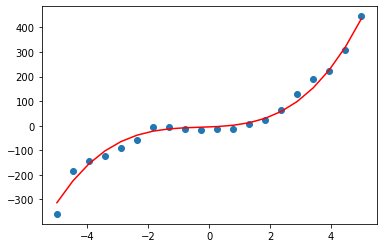

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 # pip install opencv-contrib-python

def dataset(train_size=100): # tensorflow    
     tf.random.set_seed(1)
     x = tf.linspace(-5.0, 5.0, num=train_size)
     y = 3.0*x**3 + 2.0*x**2 + x + 4.0
     y += tf.random.normal([train_size], mean=0.0, stddev = 30.0)
     return x, y
x, y_true = dataset(20)

# n-차 다항식 회귀
n = 3
X = np.ones(shape = (len(x), n+1), dtype=np.float32)
for i in range(1, n+1):
     X[:, i] = x**i

#텐서플로 모델, 학습결과 로드
fname = "./RES/frozen_graph.pb"
net =cv2.dnn.readNetFromTensorflow(fname)
##net =cv2.dnn.readNetFromTensorflow(np.fromfile(fname, dtype=np.uint8))#한글 path
##for xx in X:
##    blob = cv2.dnn.blobFromImage(xx)
##    net.setInput(blob)
##    res = net.forward()
##    print(xx, res)
     
blob = cv2.dnn.blobFromImages(X) # blob.shape = (20, 1, 4, 1)
net.setInput(blob) 
y_pred = net.forward()

plt.scatter(x, y_true) 
plt.plot(x, y_pred, color='red')
plt.show()
